# E-commerce Return Rate Anslysis

In [18]:
import pandas as pd
import mysql.connector
from datetime import datetime
import numpy as np
import mysql.connector
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
#Load the dataset
df = pd.read_csv('ecommerce_returns_synthetic_data.csv')

In [5]:
df.head(3)

,Order_ID,Product_ID,User_ID,Order_Date,Return_Date,Product_Category,Product_Price,Order_Quantity,Return_Reason,Return_Status,Days_to_Return,User_Age,User_Gender,User_Location,Payment_Method,Shipping_Method,Discount_Applied
0,ORD00000000,PROD00000000,USER00000000,2023-08-05,2024-08-26,Clothing,411.59,3,Changed mind,Returned,387.0,58,Male,City54,Debit Card,Next-Day,45.27
1,ORD00000001,PROD00000001,USER00000001,2023-10-09,2023-11-09,Books,288.88,3,Wrong item,Returned,31.0,68,Female,City85,Credit Card,Express,47.79
2,ORD00000002,PROD00000002,USER00000002,2023-05-06,NaN,Toys,390.03,5,NaN,Not Returned,NaN,22,Female,City30,Debit Card,Next-Day,26.64


# Creation of sql database

In [12]:
#MySQL connection setup

conn = mysql.connector.connect(
    host='localhost',
    user='root',         
    password='shubhamdb2002',    
    database='ecommerce_returns'
)
cursor = conn.cursor()

In [11]:

#Insert data into Users table
users = df[['User_ID', 'User_Age', 'User_Gender', 'User_Location']].drop_duplicates()
for _, row in users.iterrows():
    cursor.execute("""
        INSERT IGNORE INTO Users (User_ID, User_Age, User_Gender, User_Location)
        VALUES (%s, %s, %s, %s)
    """, tuple(None if pd.isna(x) else x for x in row))

#Insert data into Products table
products = df[['Product_ID', 'Product_Category', 'Product_Price']].drop_duplicates()
for _, row in products.iterrows():
    cursor.execute("""
        INSERT IGNORE INTO Products (Product_ID, Product_Category, Product_Price)
        VALUES (%s, %s, %s)
    """, tuple(None if pd.isna(x) else x for x in row))

#Insert data into Shipping table
shipping = df[['Order_ID', 'Payment_Method', 'Shipping_Method', 'Discount_Applied']]
for _, row in shipping.iterrows():
    cursor.execute("""
        INSERT IGNORE INTO Shipping (Order_ID, Payment_Method, Shipping_Method, Discount_Applied)
        VALUES (%s, %s, %s, %s)
    """, tuple(None if pd.isna(x) else x for x in row))

#Insert data into Orders table
orders = df[['Order_ID', 'Product_ID', 'User_ID', 'Order_Date', 'Order_Quantity']]
for _, row in orders.iterrows():
    cursor.execute("""
        INSERT IGNORE INTO Orders (Order_ID, Product_ID, User_ID, Order_Date, Order_Quantity)
        VALUES (%s, %s, %s, %s, %s)
    """, tuple(None if pd.isna(x) else x for x in row))

#Insert data into Returns table
returns = df[['Order_ID', 'Return_Date', 'Return_Status', 'Return_Reason', 'Days_to_Return']]
for _, row in returns.iterrows():
    cursor.execute("""
        INSERT IGNORE INTO Returns (Order_ID, Return_Date, Return_Status, Return_Reason, Days_to_Return)
        VALUES (%s, %s, %s, %s, %s)
    """, tuple(None if pd.isna(x) else x for x in row))


#Commit and close
conn.commit()
cursor.close()
conn.close()
print("Data inserted successfully.")

Data inserted successfully.


# Extraction and visualization 

In [15]:
#Connect to your MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='shubhamdb2002',  
    database='ecommerce_returns'
)


**Return Rate Trend By Product Category**

C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\2991136375.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  category_df = pd.read_sql("""


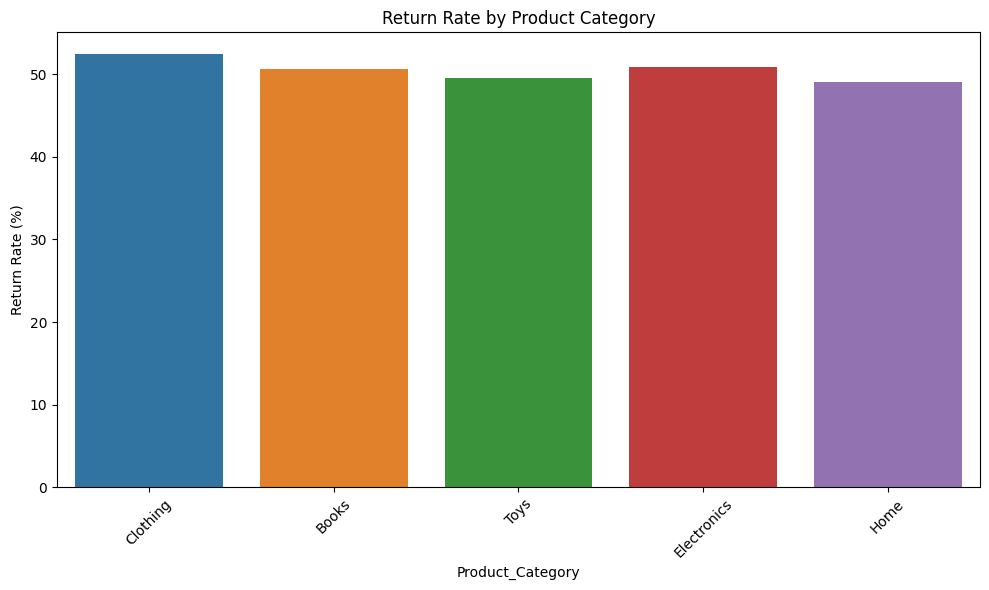

In [48]:
# Return rate by product category
category_df = pd.read_sql("""
    SELECT 
        P.Product_Category,
        COUNT(O.Order_ID) AS total_orders,
        SUM(CASE WHEN R.Return_Status = 'Returned' THEN 1 ELSE 0 END) AS total_returns
    FROM Orders O
    JOIN Products P ON O.Product_ID = P.Product_ID
    JOIN Returns R ON O.Order_ID = R.Order_ID
    GROUP BY P.Product_Category
""", conn)

category_df['Return_Rate'] = (category_df['total_returns'] / category_df['total_orders']) * 100

#Plot return rate by category
plt.figure(figsize=(10,6))
sns.barplot(data=category_df, x='Product_Category', y='Return_Rate',hue='Product_Category')
plt.xticks(rotation=45)
plt.title('Return Rate by Product Category')
plt.ylabel('Return Rate (%)')
plt.tight_layout()
plt.show()


**Return Reasons**

C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\140972018.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reason_df = pd.read_sql("""


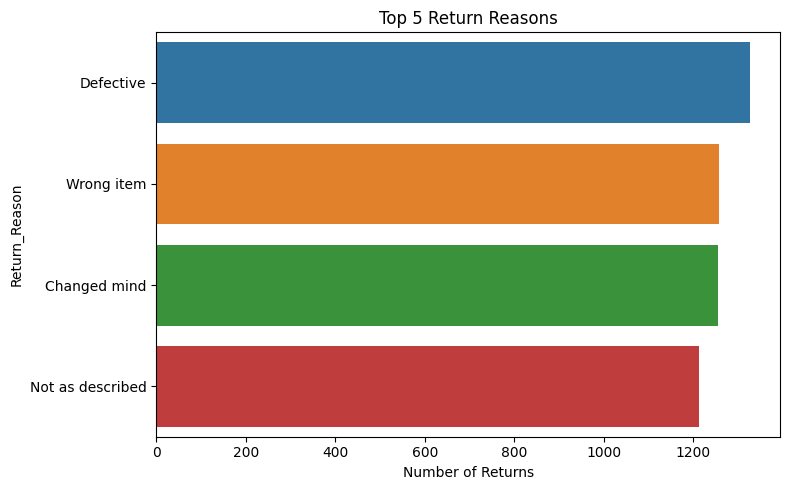

In [25]:

#Load and plot top return reasons
reason_df = pd.read_sql("""
    SELECT Return_Reason, COUNT(*) AS count
    FROM Returns
    WHERE Return_Status = 'Returned'
    GROUP BY Return_Reason
    ORDER BY count DESC
    LIMIT 5
""", conn)

plt.figure(figsize=(8,5))
sns.barplot(data=reason_df, x='count', y='Return_Reason', hue='Return_Reason')
plt.title('Top 5 Return Reasons')
plt.xlabel('Number of Returns')
plt.tight_layout()
plt.show()


**Monthly Return Rate Trend**

C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\1316455203.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  monthly_df = pd.read_sql(query, conn)


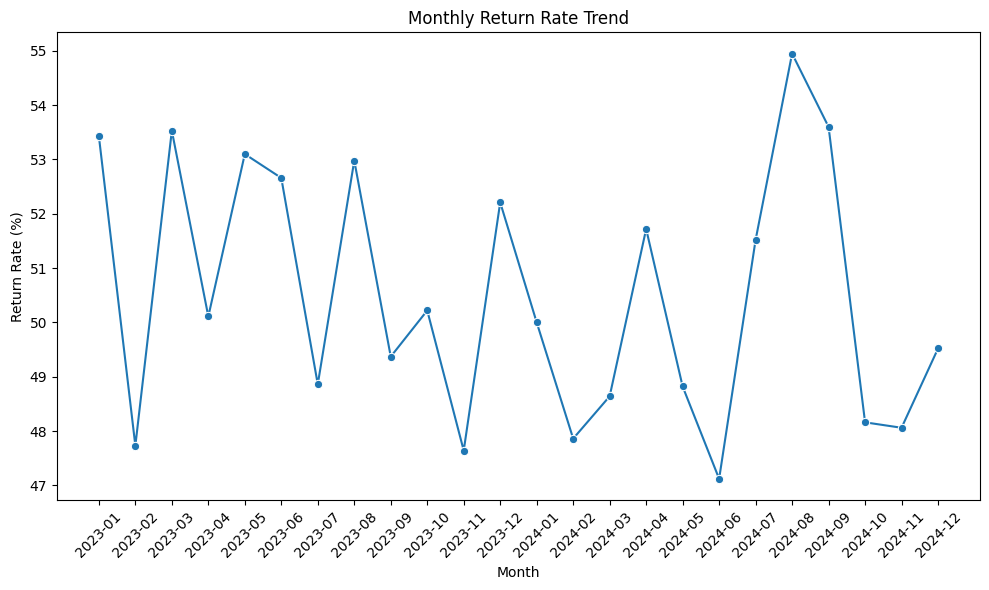

In [27]:
query = """
SELECT 
    DATE_FORMAT(O.Order_Date, '%Y-%m') AS Month,
    COUNT(O.Order_ID) AS Total_Orders,
    SUM(CASE WHEN R.Return_Status = 'Returned' THEN 1 ELSE 0 END) AS Returned_Orders,
    ROUND(SUM(CASE WHEN R.Return_Status = 'Returned' THEN 1 ELSE 0 END) / COUNT(O.Order_ID) * 100, 2) AS Return_Rate
FROM Orders O
JOIN Returns R ON O.Order_ID = R.Order_ID
GROUP BY Month
ORDER BY Month;
"""

monthly_df = pd.read_sql(query, conn)

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(data=monthly_df, x='Month', y='Return_Rate', marker='o')
plt.title('Monthly Return Rate Trend')
plt.xticks(rotation=45)
plt.ylabel('Return Rate (%)')
plt.tight_layout()
plt.show()


**Return Rate by Age Group**

C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\2222660493.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  age_df = pd.read_sql(query, conn)


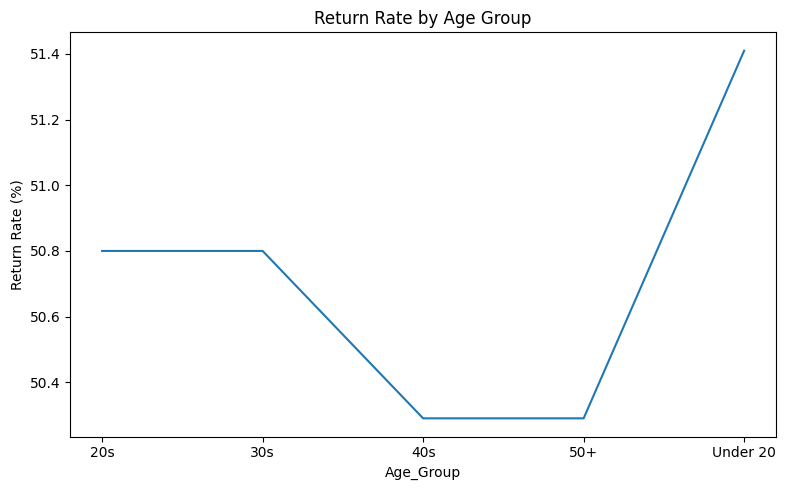

In [44]:
query = """
SELECT 
    CASE 
        WHEN U.User_Age < 20 THEN 'Under 20'
        WHEN U.User_Age BETWEEN 20 AND 29 THEN '20s'
        WHEN U.User_Age BETWEEN 30 AND 39 THEN '30s'
        WHEN U.User_Age BETWEEN 40 AND 49 THEN '40s'
        ELSE '50+'
    END AS Age_Group,
    COUNT(O.Order_ID) AS Total_Orders,
    SUM(CASE WHEN R.Return_Status = 'Returned' THEN 1 ELSE 0 END) AS Returned_Orders,
    ROUND(SUM(CASE WHEN R.Return_Status = 'Returned' THEN 1 ELSE 0 END) / COUNT(O.Order_ID) * 100, 2) AS Return_Rate
FROM Orders O
JOIN Users U ON O.User_ID = U.User_ID
JOIN Returns R ON O.Order_ID = R.Order_ID
GROUP BY Age_Group
ORDER BY Age_Group;
"""

age_df = pd.read_sql(query, conn)

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(data=age_df, x='Age_Group', y='Return_Rate')
plt.title('Return Rate by Age Group')
plt.ylabel('Return Rate (%)')
plt.tight_layout()
plt.show()


**Return Rate by Discount Level**

C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\191738622.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  discount_df = pd.read_sql(query, conn)


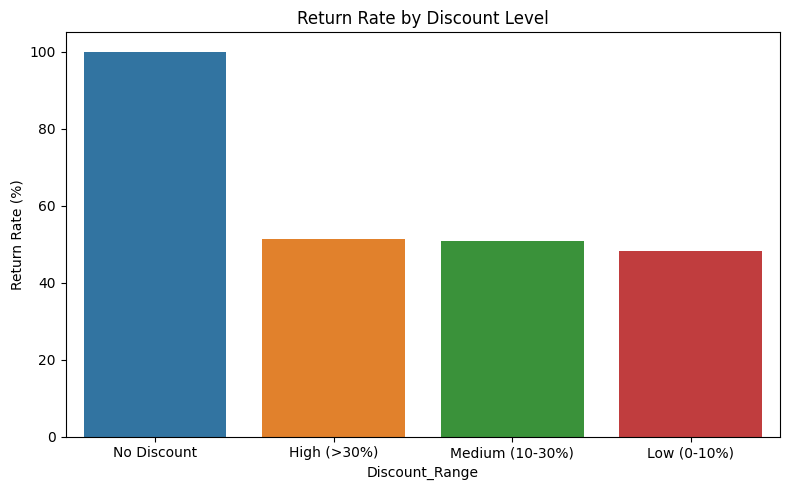

In [33]:
query = """
SELECT 
    CASE 
        WHEN S.Discount_Applied = 0 THEN 'No Discount'
        WHEN S.Discount_Applied BETWEEN 0 AND 10 THEN 'Low (0-10%)'
        WHEN S.Discount_Applied BETWEEN 10 AND 30 THEN 'Medium (10-30%)'
        ELSE 'High (>30%)'
    END AS Discount_Range,
    COUNT(O.Order_ID) AS Total_Orders,
    SUM(CASE WHEN R.Return_Status = 'Returned' THEN 1 ELSE 0 END) AS Returned_Orders,
    ROUND(SUM(CASE WHEN R.Return_Status = 'Returned' THEN 1 ELSE 0 END) / COUNT(O.Order_ID) * 100, 2) AS Return_Rate
FROM Orders O
JOIN Shipping S ON O.Order_ID = S.Order_ID
JOIN Returns R ON O.Order_ID = R.Order_ID
GROUP BY Discount_Range
ORDER BY Return_Rate DESC;
"""

discount_df = pd.read_sql(query, conn)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=discount_df, x='Discount_Range', y='Return_Rate', hue='Discount_Range')
plt.title('Return Rate by Discount Level')
plt.ylabel('Return Rate (%)')
plt.tight_layout()
plt.show()


**Return Rate Distribution by Shipping Method**

C:\Users\Asus\AppData\Local\Temp\ipykernel_9928\3178689159.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


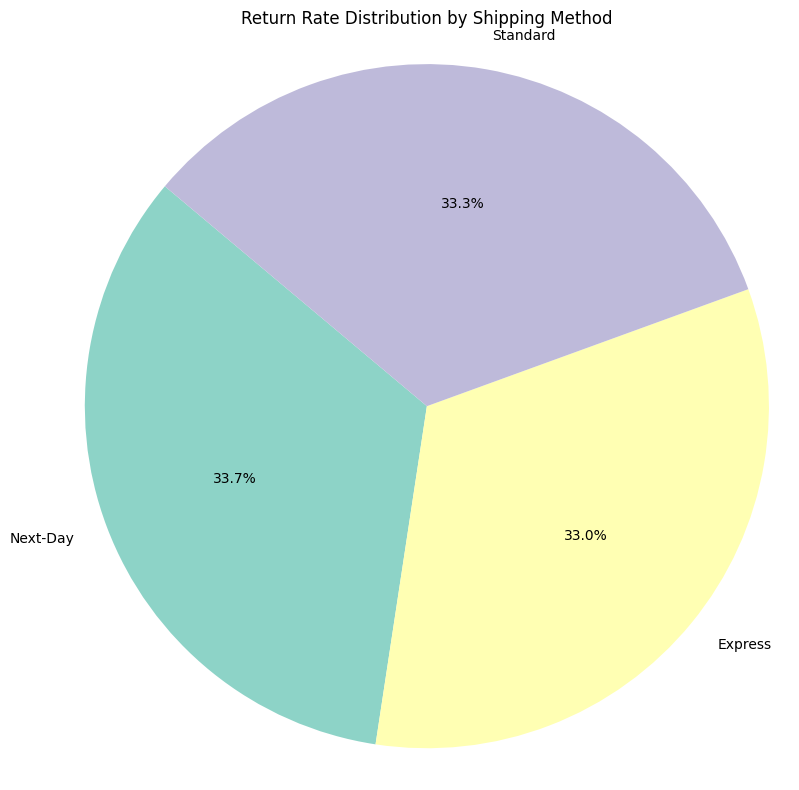

In [41]:
# Step 2: Query to get return rate by shipping method
query = """
SELECT 
    S.Shipping_Method,
    COUNT(O.Order_ID) AS Total_Orders,
    SUM(CASE WHEN R.Return_Status = 'Returned' THEN 1 ELSE 0 END) AS Returned_Orders
FROM Orders O
JOIN Shipping S ON O.Order_ID = S.Order_ID
JOIN Returns R ON O.Order_ID = R.Order_ID
GROUP BY S.Shipping_Method;
"""

df = pd.read_sql(query, conn)

# Step 3: Calculate return rate percentage for pie chart
df['Return_Rate_%'] = (df['Returned_Orders'] / df['Total_Orders']) * 100

# Step 4: Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(df['Return_Rate_%'], labels=df['Shipping_Method'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title("Return Rate Distribution by Shipping Method")
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.tight_layout()
plt.show()